**“Mapping the Pulse of NYC: Top Taxi Flows at a Glance”**

Ever wondered where NYC’s taxis really go? This project turns raw trip data into stunning interactive maps and network graphs, revealing the city’s busiest pickup-dropoff flows like never before




### **🚖 Notebook Summary**

This notebook analyzes New York City taxi trip data to identify the most frequent origin-destination (OD) flows and visualize them in two ways:

1.  **Interactive Map (Folium):**
    *   Displays a choropleth of pickup demand across taxi zones.
    *   Highlights the top 20 OD pairs with flow lines, color-coded by ride volume.
    *   Includes tooltips and popups with zone names, boroughs, and ride counts.
    *   Adds a custom legend for OD flow intensity.

2.  **Static Network Graph (Matplotlib + NetworkX):**
    *   Represents the top 20 OD pairs as a directed graph.
    *   Nodes correspond to taxi zones; edges represent flows weighted by ride volume.
    *   Edge thickness and color indicate demand intensity.
    *   Includes a colorbar for ride volume and a clear title.

**Key Steps:**

*   Load and merge taxi zone shapefiles and lookup tables.
*   Aggregate hourly trip data to compute OD demand.
*   Select top 20 OD pairs for visualization.
*   Compute centroids for mapping and apply layouts for graph visualization.
*   Export outputs:
    *   `od_flow_map.html` (interactive map)
    *   `od_flow_static.png` (static graph)

***

### **Insights**

*   **High-Demand Corridors:** The busiest OD flows are concentrated in Manhattan, particularly between Midtown and Lower Manhattan zones, reflecting strong commuter and business travel patterns.
*   **Airport Connections:** Several top OD pairs involve JFK and LaGuardia, indicating significant airport-related demand.
*   **Cross-Borough Trips:** While most flows are intra-borough, notable connections exist between Manhattan and Brooklyn, suggesting strong inter-borough travel for leisure and work.
*   **Demand Imbalance:** Pickup-heavy zones in Manhattan often serve as origins for trips to outer boroughs, highlighting directional travel trends during peak hours.


In [3]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.colors as mcolors
from branca.colormap import LinearColormap

# --- 1. Load Taxi Zones Shapefile ---
zones = gpd.read_file("data/taxi_zones/taxi_zones.shp")  # Contains LocationID and geometry

# --- 2. Load Taxi Zone Lookup for Borough and Zone Names ---
lookup = pd.read_csv("data/taxi_zones/taxi_zone_lookup.csv")  # Columns: LocationID, Borough, Zone
zones = zones.merge(lookup, on="LocationID", how="left")

# --- 3. Load Aggregated OD Demand ---
hourly = pd.read_parquet("data/daily_demand_partitioned/final")

# Aggregate OD pairs
od_pairs = hourly.groupby(['PULocationID', 'DOLocationID'])['rides'].sum().reset_index()
top_od = od_pairs.sort_values('rides', ascending=False).head(20)  # Top 20 OD pairs

# --- 4. Project Zones for Accurate Centroid Calculation ---
zones_projected = zones.to_crs(epsg=2263)  # NYC State Plane CRS

# Merge pickup zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='PULocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'PU_geometry', 'Zone': 'PUZone', 'Borough': 'PUBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# Merge drop-off zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='DOLocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'DO_geometry', 'Zone': 'DOZone', 'Borough': 'DOBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# --- 5. Compute Centroids in Projected CRS and Convert to WGS84 ---
top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid

# --- 6. Create Interactive Map ---
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add Choropleth for Pickup Demand
pickup_demand = hourly.groupby('PULocationID')['rides'].sum().reset_index()
zones_wgs84 = zones.to_crs(epsg=4326)[['LocationID', 'geometry']]

folium.Choropleth(
    geo_data=zones_wgs84.__geo_interface__,  # Convert GeoDataFrame to GeoJSON
    data=pickup_demand,
    columns=['PULocationID', 'rides'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Pickup Demand'
).add_to(m)

# --- 7. Add OD Flow Lines with Color Gradient ---
# Normalize rides for color mapping
min_rides, max_rides = top_od['rides'].min(), top_od['rides'].max()
colormap = LinearColormap(colors=['blue', 'red'], vmin=min_rides, vmax=max_rides)
colormap.caption = 'OD Flow Intensity (Rides)'

for _, row in top_od.iterrows():
    pu_lat, pu_lon = row['PU_centroid'].y, row['PU_centroid'].x
    do_lat, do_lon = row['DO_centroid'].y, row['DO_centroid'].x

    # Color based on normalized rides
    color = colormap(row['rides'])

    # Dynamic weight (capped for visibility)
    weight = min(max(row['rides'] / 50, 3), 15)

    # Tooltip text
    tooltip_text = (f"PU: {row['PUZone']} ({row['PUBorough']}) → "
                    f"DO: {row['DOZone']} ({row['DOBorough']}) | Rides: {row['rides']}")

    # Popup with mini bar chart (HTML)
    popup_html = f"""
    <div style="font-size:14px;">
        <b>OD Pair:</b><br>
        {row['PUZone']} → {row['DOZone']}<br>
        <b>Boroughs:</b> {row['PUBorough']} → {row['DOBorough']}<br>
        <b>Rides:</b> {row['rides']}<br>
        <div style="background:#ddd; width:200px; height:20px;">
            <div style="background:{color}; width:{min(row['rides']/max_rides*200,200)}px; height:20px;"></div>
        </div>
    </div>
    """

    folium.PolyLine(
        locations=[(pu_lat, pu_lon), (do_lat, do_lon)],
        color=color,
        weight=weight,
        opacity=0.8,
        tooltip=tooltip_text,
        popup=folium.Popup(popup_html, max_width=250)
    ).add_to(m)

# --- 8. Add Dynamic Color Scale Legend ---
colormap.add_to(m)

# Save interactive map
m.save("od_flow_map.html")
print("✅ Map saved as od_flow_map.html")

C:\Users\moreda\AppData\Local\Temp\ipykernel_38024\503799921.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
C:\Users\moreda\AppData\Local\Temp\ipykernel_38024\503799921.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid


✅ Map saved as od_flow_map.html


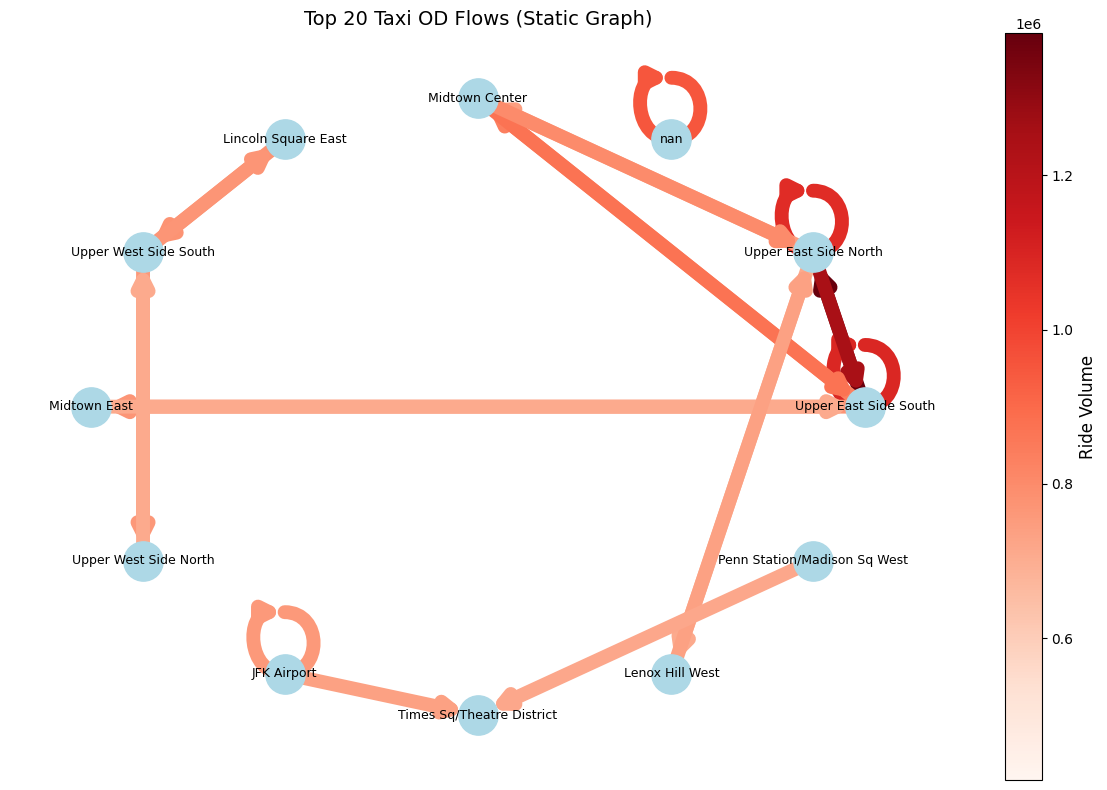

In [2]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 8))

nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', ax=ax)
nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)
nx.draw_networkx_edges(G, pos, width=weights, edge_color=colors, arrows=True, arrowsize=20, ax=ax)

# Add title and colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(top_od['rides']), vmax=max(top_od['rides'])))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Ride Volume', fontsize=12)

ax.set_title("Top 20 Taxi OD Flows (Static Graph)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.savefig("od_flow_static.png", dpi=300)
plt.show()

The static graph and interactive map highlight the most frequent taxi origin-destination flows in New York City. High-volume trips are concentrated between Midtown and Upper East Side zones, with notable flows to JFK Airport. The color gradients and line thickness visually represent ride intensity, emphasizing strong demand corridors within Manhattan and key airport connections.
